# Using ICESat-2 ATL15 (Gridded Arctic Land Ice Height) to investigate ice-surface height anomalies

### Written by 
- Wilson Sauthoff (https://wsauthoff.github.io)
- Luis Lopez (https://betolink.dev/)
- Jessica Scheick (https://eos.unh.edu/person/jessica-scheick)
- Tasha Snow (https://tsnow03.github.io)

### Key learning outcomes:
- How to gather data from disparate sources.
- What is a Coordinate Reference System (CRS) and why it matters.
- How to use geometries including Points and Polygons to define an area of interest and subset data. 
- The basics of how the icepyx library simplifies obtaining and interacting with ICESat-2 data. 
- How Xarray can simplify the import of multi-dimensional data.
- Open, plot, and explore gridded raster data.

## Computing environment

We will set up our computing environment with library imports and utility functions

Tip: If you need to import a library that is not pre-installed, use `%pip install <package-name>` alone within a Jupyter notebook cell to install it for this instance of CryoCloud (the pip installation will not presist between logins. All of the libraries we intend to use are pre-installed so we can skip this step. 

In [1]:
%pip install icepyx==1.0.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Needed for pandas read_excel
%pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib widget

# import internal libraries
import os

# import external libraries
import earthaccess
import geopandas as gpd
import h5py
import hvplot.xarray
import icepyx as ipx
# import matplotlib as mpl
# mpl.use('TkAgg') 

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer
import rioxarray
import s3fs
import xarray as xr

# define utility function
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Greenland (epsg:3413) coordinates (x, y)
    x, y = ll2ps(lon, lat)
    Inputs
    * lon, lat in decimal degrees (lon: W is negative; lat: S is negative)
    Outputs
    * x, y in [m]
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3413")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

## Greenland subglacial lakes

There are two classes of subglacial lakes: stable and active. Stable lakes have had a stable volume over the observational record whereas active episodically drain and fill. We can observe active subglacial lakes using ice-surface deformation time series. 

In this tutorial, we will focus on Greenland where active subglacial lakes have been inferred from surface height changes. 

Northern hemisphere subglacial lakes compiled in a global inventory by Livingstone and others (2020):

<img src="images/Livingstone_2020_Fig3a.png" alt="2022 inventory of subglacial lakes" class="bg-primary mb-1" width="600px">

We can investigate active subglacial lakes using ice surface height anomalies as the overlying ice deforms when active lakes drain and fill episodically. [These videos](https://svs.gsfc.nasa.gov/4913) from NASA's Science Visualization Studio illustrate how we observe active lakes filling and draining through time. 

### Locating the Greenland subglacial lakes
Consulting the supplementary data of the [Livingstone and others (2020) inventory](https://www.nature.com/articles/s43017-021-00246-9#Sec16), we can construct a [geopandas geodataframe](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) to investigate Greenland's subglacial lakes.

## Opening non-cloud-hosted data uploaded to your CryoCloud Jupyter hub

If we are working with a dataset that is not cloud hosted or unavailable via a URL, we can upload that dataset to CryoCloud. 

First, decide where the uploaded data will live on your CryoCloud hub. It could be a data directory folder that you create in your CryoCloud's base directory or put the data into your working directory (whichever file management technique you prefer). 

Second, download the paper's supplementary data by [clicking here](https://static-content.springer.com/esm/art%3A10.1038%2Fs43017-021-00246-9/MediaObjects/43017_2021_246_MOESM1_ESM.xlsx). 

Third, upload the supplementary data spreadsheet into your new data directory folder or your working directory. The supplementary data spreadsheet (.xlsx) is already uploaded to our working directory. 

In [2]:
# Read in spreadsheet using pandas read_excel
use_cols = ['Name / Location', 'Lat. oN', 'Lon. oE', 'Lake Type', 'References']
import_rows = np.arange(0,65)
# You may add a path/to/file if you'd like to try reading spreadsheet from where you saved it in a data directory 
df = pd.read_excel('43017_2021_246_MOESM1_ESM.xlsx', 'Greenland', usecols=use_cols, skiprows = lambda x: x not in import_rows)

# View pandas dataset head (first 5 rows)
df.head()

,Name / Location,Lat. oN,Lon. oE,Lake Type,References
0,NaN,78.000000,-48.000000,NaN,Ekholm et al. (1998)
1,L2,78.005022,-68.393971,Stable,Palmer et al. (2013)
2,L1,77.969500,-68.440875,Stable,Palmer et al. (2013)
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015)
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015)


However, since this data has a direct download URL, so we can read the data directly into CryoCloud skipping the download and upload steps, like so: 

## Open data directly via URL

In [3]:
# Read in spreadsheet using pandas read_excel
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs43017-021-00246-9/MediaObjects/43017_2021_246_MOESM1_ESM.xlsx'
use_cols = ['Name / Location', 'Lat. oN', 'Lon. oE', 'Lake Type', 'References']
import_rows = np.arange(0,65)
df = pd.read_excel(url, sheet_name='Greenland', usecols=use_cols, skiprows = lambda x: x not in import_rows)

# View pandas dataset head (first 5 rows)
df.head()

,Name / Location,Lat. oN,Lon. oE,Lake Type,References
0,NaN,78.000000,-48.000000,NaN,Ekholm et al. (1998)
1,L2,78.005022,-68.393971,Stable,Palmer et al. (2013)
2,L1,77.969500,-68.440875,Stable,Palmer et al. (2013)
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015)
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015)


This is looking good, but we can make it even better by storing the data in a GeoPandas GeoDataFrame which offers additional functionality beyond pandas. You can add a geometry column of Shapely objects that make geospatial data processing and visualization easier. Here we have Shapely points:

In [4]:
# Create GeoPandas GeoDataFrame from Pandas DataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['Lon. oE'], df['Lat. oN']))

# Set the Coordinate Reference System (CRS) of the geodataframe
if gdf.crs is None: 
    # set CRS WGS84 in lon, lat
    gdf.set_crs('epsg:4326', inplace=True)
    
# Display GeoDataFrame
gdf

,Name / Location,Lat. oN,Lon. oE,Lake Type,References,geometry
0,NaN,78.000000,-48.000000,NaN,Ekholm et al. (1998),POINT (-48.00000 78.00000)
1,L2,78.005022,-68.393971,Stable,Palmer et al. (2013),POINT (-68.39397 78.00502)
2,L1,77.969500,-68.440875,Stable,Palmer et al. (2013),POINT (-68.44088 77.96950)
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015),POINT (-16.58000 81.16000)
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015),POINT (-48.70900 67.61114)
...,...,...,...,...,...,...
59,Sermeq Kujalleq (Jakobshavn),69.109843,-42.055159,Stable,Bowling et al. (2019),POINT (-42.05516 69.10984)
60,Sermeq Kujalleq (Jakobshavn),69.108047,-41.954370,Stable,Bowling et al. (2019),POINT (-41.95437 69.10805)
61,Isunguata Sermia 1,67.180000,-50.188000,Active,Livingstone et al. (2019),POINT (-50.18800 67.18000)
62,Isunguata Sermia 2,67.178000,-50.149000,Active,Livingstone et al. (2019),POINT (-50.14900 67.17800)


Let's look at Greenland's active subglacial lake inventory by filtering on the Lake Type column:

In [5]:
# Let's look at Greenland's active subglacial lake inventory
gdf[gdf['Lake Type'] == 'Active']

,Name / Location,Lat. oN,Lon. oE,Lake Type,References,geometry
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015),POINT (-16.58000 81.16000)
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015),POINT (-48.70900 67.61114)
5,"Sioqqap Sermia, [SS1]",63.541856,-48.450597,Active,Bowling et al. (2019),POINT (-48.45060 63.54186)
6,"Sioqqap Sermia, [SS2]",63.260248,-48.206633,Active,Bowling et al. (2019),POINT (-48.20663 63.26025)
61,Isunguata Sermia 1,67.180000,-50.188000,Active,Livingstone et al. (2019),POINT (-50.18800 67.18000)
62,Isunguata Sermia 2,67.178000,-50.149000,Active,Livingstone et al. (2019),POINT (-50.14900 67.17800)
63,Isunguata Sermia 3,67.180000,-50.128000,Active,Livingstone et al. (2019),POINT (-50.12800 67.18000)


Now let's plot the lake locations to ensure our data read-in went as expected. But first, we need to make sure all projections for the data we want to show are the same. 

## What is a CRS/EPSG?

- A Coordinate Reference System (CRS) tells you how the Earth's 3-D surface is projected onto a 2-D plane map. Below are examples of various projections of continguous USA from an excellent [Data Carpentry tutorial on the CRS topic](https://datacarpentry.org/organization-geospatial/03-crs/): 

<img src="images/DataCarpentryCRS.jpg" alt="Coordinate Reference System comparison" class="bg-primary mb-1" width="600px">

- A particular CRS can be referenced by its EPSG code (e.g., epsg:4326 as we used in the GeoPandas GeoDataFrame example above). The EPSG is a structured dataset of CRS and Coordinate Transformations. It was originally compiled by the now defunct European Petroleum Survey Group (EPSG) but continues to be one common way of representing a specific CRS.
- Most map projections make land areas look proportionally larger or smaller than they actually are. Below is intuitive visualization of this from another excellent site of tutorials on geospatial topics called [Earth Lab](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/): 

<img src="images/EarthLabProjectionDistortion.jpg" alt="How projections distort a human head" class="bg-primary mb-1" width="600px">

- Because of this distortion, we select a projection that is best suited for the geographic region we are studying to minimize distortions.
- Previously we used epsg:4326, which is a geographic coordinate system that makes use of the World Geodetic System 1984 (WGS84) ellipsoid as a datum reference elevation. A datum consists in an ellipsoid relative to which the latitude and longitude of points are defined, with a geoid defining the surface at zero height (visual from [ESA's navipedia](https://gssc.esa.int/navipedia/index.php/Regional_Datums_and_Map_Projections)):

<img src="images/ESANavipediaDatum.png" alt="What is a datum" class="bg-primary mb-1" width="600px">

- A geographic coordinate system is more than just the ellipsoid. It adds a coordinate system and units of measurement. epsg:4326 uses the very familiar longitude and latitude and degrees as the coordinate system and units. We selected epsg:4326 because longitude and latitude were the coordinates in the dataset.
- There are numerous formats that are used to document a CRS. Three common formats include: proj.4, EPSG, and Well-known Text (WKT) formats.
- Useful websites to look up CRS strings are [spatialreference.org](Spatialreference.org) and [espg.io](https://epsg.io/). You can use the search on these sites to find an EPSG code.
- Often you have data in one format or projection (CRS) and you need to transform it to a more regionally accurate CRS or match it to another datasets' CRS to plot them together. Let’s transform our geopandas data to the NSIDC Sea Ice North Polar Stereographic projection (epsg:3413) easily visualize our lakes on a projection that minimizes distortion of our area of interest (Greenland). 

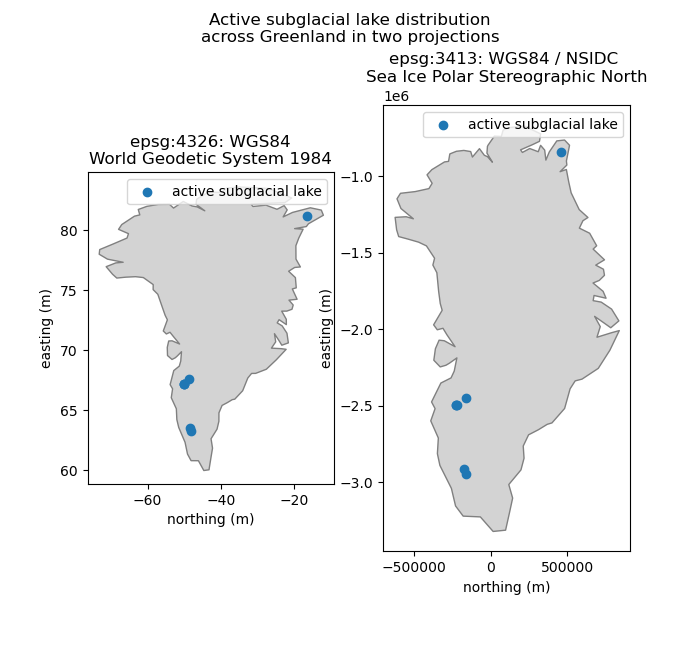

In [6]:
# Load "Natural Earth” countries dataset, bundled with GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Greenland = world[world['name'] == 'Greenland']

# Create a rough plot to ensure data was read properly
fig, axs = plt.subplots(1,2, figsize=(7,6.5))
Greenland.plot(ax=axs[0], facecolor='lightgray', edgecolor='gray')
gdf[gdf['Lake Type'] == 'Active'].plot(ax=axs[0], label='active subglacial lake')
axs[0].set_xlabel('northing (m)'); axs[0].set_ylabel('easting (m)')
axs[0].set_title('epsg:4326: WGS84\nWorld Geodetic System 1984')
axs[0].legend()
             
Greenland.to_crs('epsg:3413').plot(ax=axs[1], facecolor='lightgray', edgecolor='gray')
gdf[gdf['Lake Type'] == 'Active'].to_crs('epsg:3413').plot(ax=axs[1], label='active subglacial lake')
axs[1].set_xlabel('northing (m)'); axs[1].set_ylabel('easting (m)')
axs[1].set_title('epsg:3413: WGS84 / NSIDC \nSea Ice Polar Stereographic North')
axs[1].legend()
fig.suptitle('Active subglacial lake distribution\nacross Greenland in two projections')
plt.show()

## Using the Shapely Polygon geometry to create a search radius and subset data
- The Shapely points used before are useful to tell us the centroid of the lakes.
- However, we'd like to be able to create a search radius around that point to search for and subset data. 
- Some datasets are massive, so using Shapely polygons as a search radius around your region of interest will speed up your computation.

In [7]:
# Create GeoSeries of our GeoDataFrame that converts to Arcic polar stereographic projection 
# and makes 10-km radius buffered polygon around each lake point
gs = gdf.to_crs('3413').buffer(10000)

# Create a copy of the original GeoPandas GeoDataFrame so that we don't alter the original
gdf_polys = gdf.copy(deep=True)

# Create new GeoDataFrame to store the polygons
gdf_polys = gpd.GeoDataFrame(gdf, 
                             # We use the GeoDataFrame (gdf) copy, gdf_polys, and replaced its geometry with the GeoSeries of polygons
                             geometry=gs, 
                             # We must specify the crs, so we use the one used to create the GeoSeries of polygons
                             crs='epsg:3413'
                             # But then we switch the crs back to good ol' 4623 lon, lat
                             ).to_crs('4623')

# Look at active lakes to ensure it worked as expected
gdf_polys[gdf_polys['Lake Type'] == 'Active']

,Name / Location,Lat. oN,Lon. oE,Lake Type,References,geometry
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015),"POLYGON ((-16.06723 81.11390, -16.09787 81.106..."
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015),"POLYGON ((-48.47640 67.61446, -48.47613 67.605..."
5,"Sioqqap Sermia, [SS1]",63.541856,-48.450597,Active,Bowling et al. (2019),"POLYGON ((-48.25472 63.54482, -48.25457 63.536..."
6,"Sioqqap Sermia, [SS2]",63.260248,-48.206633,Active,Bowling et al. (2019),"POLYGON ((-48.01287 63.26285, -48.01281 63.254..."
61,Isunguata Sermia 1,67.180000,-50.188000,Active,Livingstone et al. (2019),"POLYGON ((-49.96016 67.18562, -49.95932 67.176..."
62,Isunguata Sermia 2,67.178000,-50.149000,Active,Livingstone et al. (2019),"POLYGON ((-49.92117 67.18356, -49.92035 67.174..."
63,Isunguata Sermia 3,67.180000,-50.128000,Active,Livingstone et al. (2019),"POLYGON ((-49.90015 67.18552, -49.89933 67.176..."


Now that we know our active lake locations, let’s grab data to study the filling and draining of the lakes. We will use ICESat-2 surface elevations to investigate.

## What is ICESat-2?

ICESat-2 (Ice, Cloud, and land Elevation Satellite 2), part of NASA's Earth Observing System, is a satellite mission for measuring ice sheet elevation and sea ice thickness, as well as land topography, vegetation characteristics, and clouds. It does so using an altimeter or an altitude meter, which is an instrument used to measure the altitude of an object above a fixed level (the datum we talked about earlier). This is typically achieved by measuring the time it takes for a lidar or radar pulse, released by a satellite-based altimeter, to travel to a surface, reflect, and return to be recorded by an onboard instrument. ICESat-2 uses three pairs of laser pulsers and the detector to count the reflected photons. 

ICESat-2 laser configuration (from [Smith and others, 2019](https://doi.org/10.1016/j.rse.2019.111352)): 

<img src="images/Smith_2019_fig1.jpg" alt="ICESat-2 laser configuration" class="bg-primary mb-1" width="1000px">

## What is ATL14/15?
ATL15 is one of the various [ICESat-2 data products](https://icesat-2.gsfc.nasa.gov/science/data-products). ATL15 provides various resolutions (1 km, 10 km, 20 km, and 40 km) of gridded raster data of height change at 3-month intervals, allowing for visualization of height-change patterns and calculation of integrated active subglacial lake volume change (Smith and others, 2022).

ATL14 is an accompnaying high-resolution (100 m) digital elevation model (DEM) that provides spatially continuous gridded data of ice sheet surface height.

Learn more about the ICESat-2 ATL14/15 Gridded Antarctic and Arctic Land Ice Height Change data product dataset [here](https://doi.org/10.5067/ATLAS/ATL15.002).

## Streaming cloud-hosted data from NASA Earth Data Cloud
We will be working with cloud-hosted data files. This [guide](https://nsidc.org/data/user-resources/help-center/nasa-earthdata-cloud-data-access-guide) explains how to find and access Earthdata cloud-hosted data. [Here](https://nsidc.org/data/earthdata-cloud) is a complete list of earthdata cloud-hosted data products currently available from NSIDC.

### Using icepyx to simplify searching for ICESat-2 data
[icepyx](https://icepyx.readthedocs.io/en/latest/) is a community and Python software library that simplifies the process of searching (querying), accessing (via download or in the cloud), and working with (including subsetting, visualizing, and reading in) ICESat-2 data products. A series of [examples](https://github.com/icesat2py/icepyx/tree/main/doc/source/example_notebooks) introduce users to its functionality, and the icepyx community always welcomes new members, feature requests, bug reports, etc.

To search for data spatially, icepyx accepts shapefiles, kml files, and geopackage files, as well as bounding boxes and polygons, as input bounding regions. So we'll first save one of the lakes' geometries as a geopackage and use it to query ICESat-2 data for that region.

In [8]:
# Export to geopackage to subset ICESat-2 data
gdf_polys[gdf_polys['Name / Location'] == 'Flade Isblink ice cap'].to_file(os.getcwd() + '/Flade_Isblink_poly.gpkg')

In [9]:
# Specifying the necessary icepyx parameters
short_name = 'ATL15'  # The data product we would like to query
spatial_extent = 'Flade_Isblink_poly.gpkg'
date_range = ['2018-09-15','2023-03-02']

In [10]:
# Setup the Query object
region = ipx.Query(short_name, spatial_extent, date_range)

We can visualize our spatial extent on an interactive map with background imagery.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
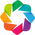

:Overlay
   .WMTS.I :WMTS   [Longitude,Latitude]
   .Path.I :Path   [Longitude,Latitude]

In [11]:
# Visualize area of interest
region.visualize_spatial_extent()

In [12]:
# Let's find out some information about the available data granuales (files)
region.avail_granules()

{'Number of available granules': 4,
 'Average size of granules (MB)': 193.56415557861328,
 'Total size of all granules (MB)': 774.2566223144531}

In [14]:
ipx.__version__

'1.0.0'

In [15]:
# Let's see the granule IDs and cloud access urls
gran_ids = region.avail_granules(ids=True, cloud=True)
gran_ids
s3url='s3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'

In [15]:
# Let's grab the s3 URL of the highest resolution available product
s3url = gran_ids[1][3]
s3url

's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'

You can manually find s3 URL's for cloud-hosted data from [NASA Earth Data](https://www.earthdata.nasa.gov/)

Learn more about finding cloud-hosted data from NASA Earth data cloud [here](https://nsidc.org/data/user-resources/help-center/nasa-earthdata-cloud-data-access-guide)

The next step (accessing data in the cloud) requires a NASA Earthdata user account.
You can register for a free account [here](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/earthdata-login).
icepyx will automatically ask for your credentials when you perform a task that needs them.
If you do not have them stored as environment variables or in a .netrc file, you will be prompted to enter them.

In [19]:
# set up our s3 file system using our credentials
s3 = earthaccess.get_s3fs_session(daac='NSIDC', provider=region._s3login_credentials)

In [20]:
# Open s3url data file and store in Xarray Dataset
# This cell takes 10s of secs to load
with s3.open(s3url,'rb') as f:
    # ATL15_dh = rioxarray.open_rasterio(f, group='delta_h').load()  # FIXME: preferred, but giving error
    ATL15_dh = xr.open_dataset(f, group='delta_h').load()

# View Xarray Dataset
ATL15_dh

<xarray.Dataset>
Dimensions:              (x: 1541, y: 2701, time: 15)
Coordinates:
  * x                    (x) float64 -6.7e+05 -6.69e+05 ... 8.69e+05 8.7e+05
  * y                    (y) float64 -3.35e+06 -3.349e+06 ... -6.51e+05 -6.5e+05
  * time                 (time) datetime64[ns] 2018-10-01T22:30:00 ... 2022-0...
Data variables:
    Polar_Stereographic  int8 -127
    ice_area             (time, y, x) float32 nan nan nan nan ... nan nan nan
    delta_h              (time, y, x) float32 nan nan nan nan ... nan nan nan
    delta_h_sigma        (time, y, x) float32 nan nan nan nan ... nan nan nan
    data_count           (time, y, x) float32 nan nan nan nan ... nan nan nan
    misfit_rms           (time, y, x) float32 nan nan nan nan ... nan nan nan
    misfit_scaled_rms    (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    description:  delta_h group includes variables describing height differen...

In [17]:
reader = ipx.Read(s3url)

Enter your Earthdata Login username:  icepyx_devteam
Enter your Earthdata password:  ········


In [22]:
# Indicate which variables you'd like to read in.
# More information on managing ICESat-2 variables is available in the icepyx documentation and examples.
reader.vars.append(var_list=["delta_h"])

ValueError: list.remove(x): x not in list

We can acquaint ourselves with this dataset in a few ways: 
- The data product's [overview page](https://doi.org/10.5067/ATLAS/ATL15.002) (Smith and others, 2022) to get the very basics such as geographic coverage, CRS, and what the data product tells us (quarterly height changes).
- The Xarray Dataset read-in metadata: clicking on the written document icon of each data variable will expand metadata including a data variable's dimensions, datatype, etc. 
- The data product's [data dictionary](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl15_data_dict_v002.pdf) (Smith and others, 2021) to do a deep dive on what individual variables tell us. 
- THe data product's [Algorithm Theoretical Basis Document](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL14_ATL15_ATBD_r001.pdf)

We'll be plotting the delta_h data variable in this tutorial, here's what we can learn about from these sources:
- [ATL14/15's overview page](https://doi.org/10.5067/ATLAS/ATL15.002): this is likely the 'quarterly height changes' described, but let's dive deeper to be sure
- ATL14/15's Xarray Dataset imbedded metadata tells us a couple things: delta_h =height change  at 1 km (the resolution selected earlier) and height change relative to the datum (Jan 1, 2020) surface
- [ATL14/15's data dictionary](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl15_data_dict_v002.pdf): delta_h = quarterly height change at 40 km

Ok, since the data is relative to a datum, we have two options: 
1) Difference individual time slices to subtract out the datum, like so: 

    (time$_0$ - datum) - (time$_1$ - datum) = time$_0$ - datum - time$_1$ + datum = time$_0$ - time$_1$

2) Subtract out the datum directly. The datum is the complementary dataset high-resolution DEM surface contained in tha accompanying dataset ATL14.

In this tutorial we'll use the first method. We'll use some explanatory data analysis to illustrate this.  

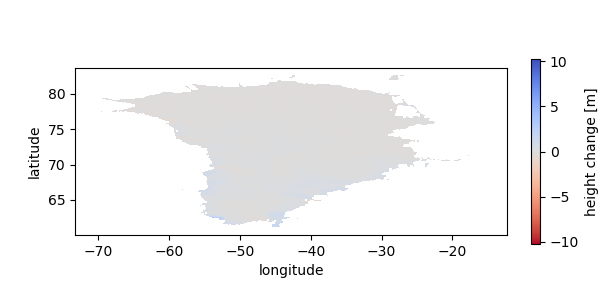

In [20]:
# Let's make a simple plot of the first minus the zeroth time slices
fig, ax = plt.subplots(figsize=(6,3))
dhdt = ATL15_dh['delta_h'][1,:,:] - ATL15_dh['delta_h'][0,:,:]
cb = ax.imshow(dhdt, origin='lower', norm=colors.CenteredNorm(), cmap='coolwarm_r', 
               extent=[Greenland.bounds.minx.values[0], Greenland.bounds.maxx.values[0], Greenland.bounds.miny.values[0], Greenland.bounds.maxy.values[0]])
ax.set_xlabel('longitude'); ax.set_ylabel('latitude')
plt.colorbar(cb, fraction=0.02, label='height change [m]')
plt.show()

Hmmm...doesn't look like much change over this quarter. Why? Check out the bounds of the colorbar, we've got some pretty extreme values (colorbar is defaulting to ±10 m!) that appear to be along the margin. It's making more sense now. We can change the bounds of the colorbar to plot see more of the smaller scale change in the continental interior.

In [21]:
# Let's calculate some basic stats to determine appropriate coloarbar bounds
print(dhdt.min().values)
print(dhdt.max().values)

-3.6538086
10.285828


We can use a TwoSlopeNorm to achieve different mapping for positive and negative values while still keeping the center at zero:

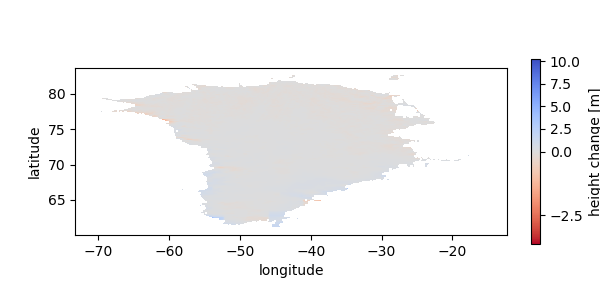

In [22]:
# We can make that same plot with more representative colorbar bounds
fig, ax = plt.subplots(figsize=(6,3))
dhdt = ATL15_dh['delta_h'][1,:,:] - ATL15_dh['delta_h'][0,:,:]
divnorm = colors.TwoSlopeNorm(vmin=dhdt.min(), vcenter=0, vmax=dhdt.max())
cb = ax.imshow(dhdt, origin='lower', norm=divnorm, cmap='coolwarm_r', 
               extent=[Greenland.bounds.minx.values[0], Greenland.bounds.maxx.values[0], Greenland.bounds.miny.values[0], Greenland.bounds.maxy.values[0]])
ax.set_xlabel('longitude'); ax.set_ylabel('latitude')
plt.colorbar(cb, fraction=0.02, label='height change [m]')
plt.show()

Now the colorbar bounds are more representative, but we still have the issue that extreme values along the margin are swapping any signals we might see in the continental interior. 

In [23]:
# Let's use the Xarray DataArray quantile method to find the 1% and 99% quantiles (Q1 and Q3) of the data
dhdt.quantile([0.01,0.99])

<xarray.DataArray 'delta_h' (quantile: 2)>
array([-0.37408447,  1.45697021])
Coordinates:
  * quantile  (quantile) float64 0.01 0.99

We can use these quantiles as the colorbar bounds so that we see the data variability by plotting the most extreme values at the maxed out value of the colorbar. We'll adjust the caps of the colorbar (using `extend`) to express that there are data values beyond the bounds. 

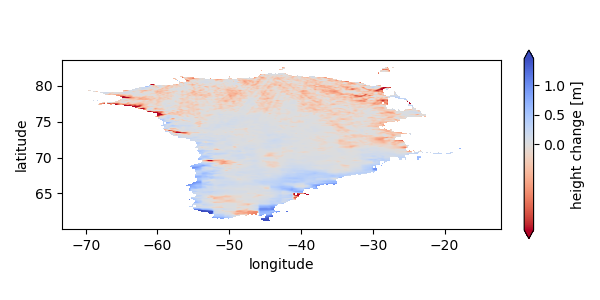

In [24]:
# Let's make the same plot but using the quantiles as the colorbar bounds
fig, ax = plt.subplots(figsize=(6,3))
dhdt = ATL15_dh['delta_h'][1,:,:] - ATL15_dh['delta_h'][0,:,:]
divnorm = colors.TwoSlopeNorm(vmin=dhdt.quantile(0.01), vcenter=0, vmax=dhdt.quantile(0.99))
cb = ax.imshow(dhdt, origin='lower', norm=divnorm, cmap='coolwarm_r', 
               extent=[Greenland.bounds.minx.values[0], Greenland.bounds.maxx.values[0], Greenland.bounds.miny.values[0], Greenland.bounds.maxy.values[0]])
ax.set_xlabel('longitude'); ax.set_ylabel('latitude')
plt.colorbar(cb, fraction=0.02, extend='both', label='height change [m]')
plt.tight_layout()
plt.show()

In [25]:
# Let's make the same plot but for all the available time slices and let's turn it in a function so that we can reuse this code for a smaller subset of data
# create empty lists to store data
def plot_icesat2_atl15(xmin, xmax, ymin, ymax, dataset):
    # subset data using bounding box in epsg:3134 x,y
    mask_x = (dataset.x >= xmin) & (dataset.x <= xmax)
    mask_y = (dataset.y >= ymin) & (dataset.y <= ymax)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    
    # Create empty lists to store data
    vmins_maxs = []

    # Find the min's and max's of each inter time slice comparison and store into lists
    for idx in range(len(ds_sub['time'].values)-1): 
        dhdt = ds_sub['delta_h'][idx+1,:,:] - ds_sub['delta_h'][idx,:,:]
        vmin=dhdt.quantile(0.01)
        vmins_maxs += [vmin]
        vmax=dhdt.quantile(0.99)
        vmins_maxs += [vmax]
        if (min(vmins_maxs)<0) & (max(vmins_maxs)>0):
            vcenter = 0
        else: 
            vcenter = max(vmins_maxs) - min(vmins_maxs)
        divnorm = colors.TwoSlopeNorm(vmin=min(vmins_maxs), vcenter=vcenter, vmax=max(vmins_maxs))

    # create fig, ax
    fig, axs = plt.subplots(7,2, sharex=True, sharey=True, figsize=(10,10))

    idx = 0
    for ax in axs.ravel():   
        ax.set_aspect('equal')
        dhdt = ds_sub['delta_h'][idx+1,:,:] - ds_sub['delta_h'][idx,:,:]
        cb = ax.imshow(dhdt, origin='lower', norm=divnorm, cmap='coolwarm_r', 
                       extent=[xmin[0], xmax[0], ymin[0], ymax[0]])
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)
        # Create common axes labels
        fig.supxlabel('easting (km)'); fig.supylabel('northing (km)')
        # Increment the idx
        idx = idx + 1
     
    fig.colorbar(cb, extend='both', ax=axs.ravel().tolist(), label='height change [m]')
    plt.show()

Let's zoom into an individual active lake to see more detail. First let's remind ourselves of the Greenland active subglacial lakes by filtering on lake type:

In [26]:
gdf_polys_active = gdf_polys[gdf_polys['Lake Type'] == 'Active']
gdf_polys_active

,Name / Location,Lat. oN,Lon. oE,Lake Type,References,geometry
3,Flade Isblink ice cap,81.160000,-16.580000,Active,Willis et al. (2015),"POLYGON ((-16.06723 81.11390, -16.09787 81.106..."
4,Inuppaat Quuat,67.611136,-48.709000,Active,Howat et al. (2015); Palmer et al. (2015),"POLYGON ((-48.47640 67.61446, -48.47613 67.605..."
5,"Sioqqap Sermia, [SS1]",63.541856,-48.450597,Active,Bowling et al. (2019),"POLYGON ((-48.25472 63.54482, -48.25457 63.536..."
6,"Sioqqap Sermia, [SS2]",63.260248,-48.206633,Active,Bowling et al. (2019),"POLYGON ((-48.01287 63.26285, -48.01281 63.254..."
61,Isunguata Sermia 1,67.180000,-50.188000,Active,Livingstone et al. (2019),"POLYGON ((-49.96016 67.18562, -49.95932 67.176..."
62,Isunguata Sermia 2,67.178000,-50.149000,Active,Livingstone et al. (2019),"POLYGON ((-49.92117 67.18356, -49.92035 67.174..."
63,Isunguata Sermia 3,67.180000,-50.128000,Active,Livingstone et al. (2019),"POLYGON ((-49.90015 67.18552, -49.89933 67.176..."


In [27]:
# We can call the bounds of the geometry of the Shapely Polygon we created earlier
gdf_sub = gdf_polys_active[gdf_polys_active['Name / Location'] == 'Inuppaat Quuat']

Now using these geometry bounds we can plot the area immediately around the active subglacial lake. 

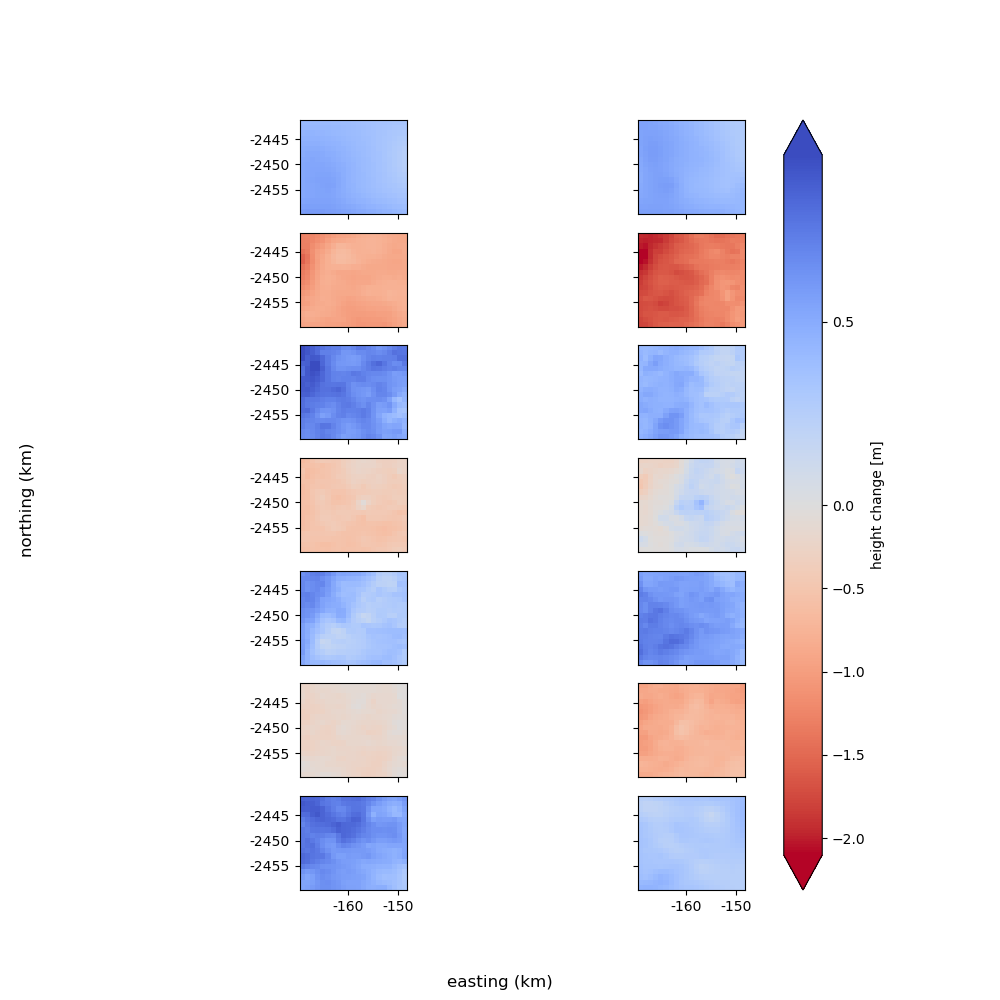

In [28]:
# If the figure doesn't pop up, it is because the holoviews plot was run immediately after and interferred with 
# matplotlib. Just rerun this cell and it will be fixed
%matplotlib widget

# Assigning the min, max lon, lat coords of the lower-left and upper-right corners of our bounding box 
# around the lake's buffer polygon
lon_min = gdf_sub.geometry.bounds.minx
lon_max = gdf_sub.geometry.bounds.maxx
lat_min = gdf_sub.geometry.bounds.miny
lat_max = gdf_sub.geometry.bounds.maxy

# Now we re-project the lon, lat into x, y coords in the 3413 CRS, which ATL15 uses
xmin, ymin = ll2ps(lon_min, lat_min)
xmax, ymax = ll2ps(lon_max, lat_max)

# Use our plotting fuction to plot up the data based on min, max x, y bounds
plot_icesat2_atl15(xmin, xmax, ymin, ymax, ATL15_dh)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=14, width=550)
        [2] HSpacer()
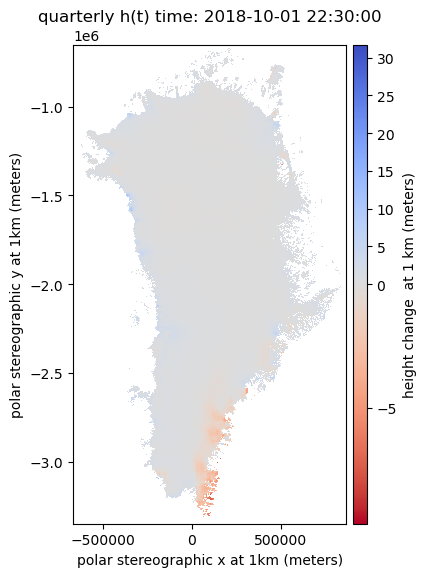

In [29]:
# Let's explore plotting the data interactively using Xarray and Holoviews
hvplot.extension('matplotlib')
divnorm = colors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=1.25)
ATL15_dh['delta_h'].hvplot(groupby='time', cmap='coolwarm_r', norm=divnorm, invert=True, 
                           width=(ATL15_dh['x'].max()-ATL15_dh['x'].min())/3e3, height=(ATL15_dh['y'].max()-ATL15_dh['y'].min())/3e3, 
                           widget_type='scrubber', widget_location='bottom')

In [30]:
# clean up environment by deleting intermediary files
os.remove('Flade_Isblink_poly.gpkg')

## Streaming cloud-hosted data via earthaccess
We will next use earthaccess to authenicate for NASA EarthData, and search and stream cloud-hosted data directly. 

<!-- DELETE -->
<!-- ***
IMPORTANT: Restart the kernel to ensure these recent changes are implemented in the computing environment.
On CryoCloud's top menu: click Kernel>Restart Kernel...
*** -->

In [32]:
# Import earthaccess Library and view version
import earthaccess
print(f"Using earthaccess v{earthaccess.__version__}")

Using earthaccess v0.5.3


### Log into NASA's Earthdata using the earthaccess package

There are multiple ways to provide your Earthdata credentials via [earthaccess](https://nsidc.github.io/earthaccess/). The [earthaccess authentication class](https://nsidc.github.io/earthaccess/tutorials/restricted-datasets/#auth) automatically tries three methods for getting user credentials to log in:
1) with `EARTHDATA_USERNAME` and `EARTHDATA_PASSWORD` environment variables
2) through an interactive, in-notebook login (used below); passwords are not shown plain text
3) with stored credentials in a .netrc file (not recommended for security reasons)

In [37]:
# Try to authenticate
auth = earthaccess.login()
print(auth.authenticated)

We are already authenticated with NASA EDL
True


### Search for cloud-available datasets from NASA

In [35]:
# Using a keyword search

from pprint import pprint
datasets = earthaccess.search_datasets(keyword="SENTINEL",
                                       cloud_hosted=True)

for dataset in datasets[0:2]:
    pprint(dataset.summary())

Datasets found: 131
{'concept-id': 'C1595422627-ASF',
 'file-type': '',
 'get-data': [],
 'short-name': 'SENTINEL-1_INTERFEROGRAMS',
 'version': '1'}
{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['s3://lp-prod-protected/HLSS30.020',
                                                 's3://lp-prod-public/HLSS30.020'],
                'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'},
 'concept-id': 'C2021957295-LPCLOUD',
 'file-type': "[{'Format': 'Cloud Optimized GeoTIFF (COG)', 'FormatType': "
              "'Native', 'Media': ['Earthdata Cloud', 'HTTPS'], "
              "'AverageFileSize': 20.0, 'AverageFileSizeUnit': 'MB', "
              "'TotalCollectionFileSizeBeginDate': "
              "'2015-11-28T00:00:00.000Z'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C2021957

In [36]:
# Using a known short name
datasets = earthaccess.search_datasets(short_name="HLSS30",
                                       cloud_hosted=True)
for dataset in datasets:
    pprint(dataset.summary())
    pprint(dataset.abstract())

Datasets found: 1
{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['s3://lp-prod-protected/HLSS30.020',
                                                 's3://lp-prod-public/HLSS30.020'],
                'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'},
 'concept-id': 'C2021957295-LPCLOUD',
 'file-type': "[{'Format': 'Cloud Optimized GeoTIFF (COG)', 'FormatType': "
              "'Native', 'Media': ['Earthdata Cloud', 'HTTPS'], "
              "'AverageFileSize': 20.0, 'AverageFileSizeUnit': 'MB', "
              "'TotalCollectionFileSizeBeginDate': "
              "'2015-11-28T00:00:00.000Z'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C2021957295-LPCLOUD',
              'https://appeears.earthdatacloud.nasa.gov/'],
 'short-name': 'HLSS30',
 'version': '2.0'}
('The Harmoniz

### Searching for granules (files) from a given collection (dataset)
earthaccess has two different ways of querying for data:
1) We can build a query object or 
2) we can use the top level API. 

The difference is that the query object is a bit more flexible and we don't retrieve the metadata from CMR until we execute the `.get()` or `.get_all()` methods.

Let's use [bboxfinder.com](http://bboxfinder.com) to get the extent of our bounding box and enter it into our bounding box input below. You are also welcome to put in a bounding box you already have available. You can uncomment the Iceland bounding box if you don't want to find your own. Order should be: `min_lon, min_lat, max_lon, max_lat`

In [37]:
# Using a specific concept-id, which is unique to the specific product and version

# bbox for ~Iceland is -22.1649, 63.3052, -11.9366, 65.5970 
granules_query = earthaccess.granule_query().cloud_hosted(True) \
        .concept_id("C2021957295-LPCLOUD") \
        .bounding_box(-22.1649, 63.3052, -11.9366, 65.5970) \
        .temporal("2020-01-01","2023-01-01")
granules_query.params

{'concept_id': ['C2021957295-LPCLOUD'],
 'bounding_box': '-22.1649,63.3052,-11.9366,65.597',
 'temporal': ['2020-01-01T00:00:00Z,2023-01-01T00:00:00Z']}

In [38]:
granules_query.hits()

5380

Earthaccess has many methods we can use for our search. For a complete list of the parameters we can use, go to [https://nsidc.github.io/earthaccess/user-reference/granules/granules-query/](https://nsidc.github.io/earthaccess/user-reference/granules/granules-query/)

In [39]:
granule = granules_query.get(1)[0]
granule.data_links()

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B09.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B05.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B10.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B03.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B08.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2020048T131259.v2.0/HLS.S30.T27VWL.2020048T131259.v2.0.B06.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30

### Downloading granules

**IMPORTANT**: Some datasets will require users to accept an EULA (end user license agreement), it is advisable trying to download a single granule using our browser first and see if we get redirected to a NASA form.

<img src="images/EULA.png" alt="NASA end user license agreement)" class="bg-primary mb-1" width="800px">

### Streaming data with earthaccess
If we have enough RAM (memory), we can load our granules from an S3 bucket into memory. Earthaccess works with fsspec (xarray, h5netcdf) at the moment, so this is task is better suited for Level 3 and Level 4 netcdf datasets.

We are going to select a few granules for the same day in February for 5 years.

In [40]:
iceland_bbox = (-22.1649, 63.3052, -11.9366, 65.5970)
# We are going to save our granules for each year on this list
granule_list = []

for year in range(2018, 2023):
    print(f"Querying {year}")
    granules = earthaccess.search_data(
        short_name = "HLSS30",
        bounding_box = iceland_bbox,
        temporal = (f"{year}-02-17", f"{year}-02-18")
    )
    granule_list.extend(granules)

Querying 2018
Granules found: 1
Querying 2019
Granules found: 2
Querying 2020
Granules found: 2
Querying 2021
Granules found: 4
Querying 2022
Granules found: 3


In [41]:
scene = granule_list[0]
scene

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -20.77975676, 'Latitude': 63.04157071}, {'Longitude': -19.80583813, 'Latitude': 64.02224734}, {'Longitude': -21.00040929, 'Latitude': 64.02715388}, {'Longitude': -21.00039541, 'Latitude': 63.041742}, {'Longitude': -20.77975676, 'Latitude': 63.04157071}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-02-17T13:12:50.460Z', 'EndingDateTime': '2018-02-17T13:12:50.460Z'}}
Size(MB): 72.62060165405273
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B8A.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B12.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.B11.tif']

Retrieve the data link. "Direct" indicates an S3 bucket in the cloud, which you can stream from. "External" indicates an HTTPS link which is not cloud-based. Direct access link will allow you to stream the data, but you can also open from HTTPS into memory if it's the right file format (generally formats that Xarray can open). 

In [42]:
print("Direct access links: ", scene.data_links(access="direct")[0])
print("External links: ", scene.data_links(access="external")[0])

Direct access links:  s3://lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.VAA.tif
External links:  https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T27VWL.2018048T131249.v2.0/HLS.S30.T27VWL.2018048T131249.v2.0.VAA.tif


 Opening 1 granules, approx size: 0.07 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

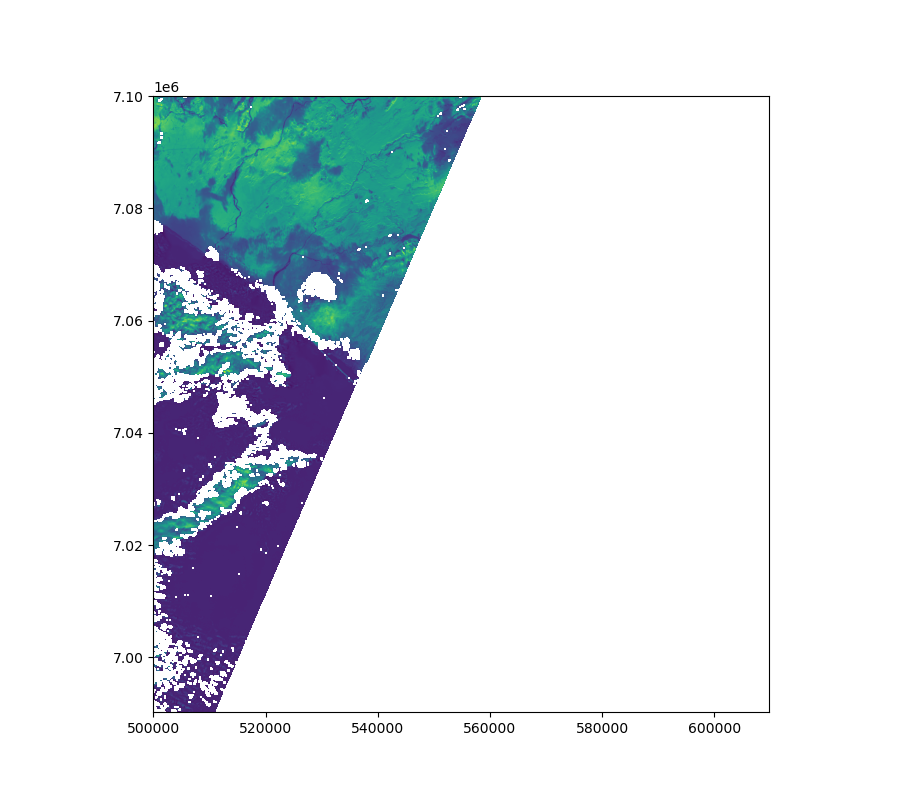

In [43]:
%matplotlib widget
import rasterio as rio
from rasterio.plot import show
import xarray as xr

# Read and plot with grid coordinates 
with rio.open(earthaccess.open(granule_list[1:2])[0]) as src:
    fig, ax = plt.subplots(figsize=(9,8))

    # To plot
    show(src,1)

    # To open data into a numpy array
    profile = src.profile
    arr = src.read(1)

In [44]:
hls_scene = xr.open_dataset(earthaccess.open(granule_list[1:2])[0], engine='rasterio')
hls_scene

 Opening 1 granules, approx size: 0.07 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (band: 1, x: 3660, y: 3660)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 7.1e+06 7.1e+06 7.1e+06 ... 6.99e+06 6.99e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

### Working with legacy data formats

**MOD07_L2** is an HDF EOS dataset providing atmospheric profiles from the MODerate Resolution Imaging Spectroradiometer instrument on the Terra satelite. You could use this data for providing an atmospheric correction for imagery to get a surface reflectance measurement. 

It is in a very old HDF data format and although streaming is technically possible, the only libraries that can open HDF EOS expect file paths not remote file systems like the one used by xarray (fsspec). So instead will access the netCDF endpoint via Opendap to download the granules instead of streaming them.

In [45]:
iceland_bbox = (-22.1649, 63.3052, -11.9366, 65.5970)

granules = earthaccess.search_data(
    short_name = "MOD07_L2",
    bounding_box = iceland_bbox,
    temporal = (f"2020-01-01", f"2020-01-02")
)

Granules found: 9


In [46]:
print("Direct access link: ", granules[0].data_links(access="direct"))
print("External link: ", granules[0].data_links(access="external"))

Direct access link:  ['s3://prod-lads/MOD07_L2/MOD07_L2.A2020001.0015.061.2020002183420.hdf']
External link:  ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf']


If we try to open these HDF files in Xarray:

In [ ]:
# This creates an anticipated error
mod07 = xr.open_mfdataset(earthaccess.open(granules[0:3]), engine='rasterio')

We notice that the access occurs quickly, but xarray is unable to recognize the legacy file format. HDF files are remarkably hard to open. You must download the files and open using pyhdf to open them using code like this: \
`from pyhdf.SD import SD,SDC` \
`mod07_l2 = SD(MODfile, SDC.READ)`

We do have another option to convert hdf to nc4 files during download so that we can open the files in Xarray.

In [48]:
# We are going to retrieve the html endpoint link for one granule
granules[0]._filter_related_links("USE SERVICE API")

['https://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf.html']

In [49]:
netcdf_list = [g._filter_related_links("USE SERVICE API")[0].replace(".html", ".nc4") for g in granules]
netcdf_list[0]

'https://ladsweb.modaps.eosdis.nasa.gov/opendap/RemoteResources/laads/allData/61/MOD07_L2/2020/001/MOD07_L2.A2020001.0015.061.2020002183420.hdf.nc4'

In [50]:
# This is going to be slow as we are asking Opendap to format HDF into NetCDF4 so we only processing 3 granules
# and Opendap is very prone to failures due concurrent connections, not ideal.
# Convert the list from HDF to netcdf4, then download.
file_handlers = earthaccess.download(netcdf_list[0:3], local_path="test_data", threads=4)

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
import os

# Get the file names
path = "test_data"
dir_list = os.listdir(path)
print(dir_list)

['MOD07_L2.A2020001.0015.061.2020002183420.hdf.nc4', '.ipynb_checkpoints', 'MOD07_L2.A2020001.1335.061.2020002184119.hdf.nc4', 'MOD07_L2.A2020001.1200.061.2020002184553.hdf.nc4']


In [52]:
cd test_data

/home/jovyan/CryoCloudWebsite/book/tutorials/IS2_ATL15_surface_height_anomalies/test_data


In [53]:
# Open a file into xarray for analysis
ds = xr.open_dataset(dir_list[0])
ds

<xarray.Dataset>
Dimensions:                            (Band_Number: 12, Pressure_Level: 20,
                                        Cell_Along_Swath: 406,
                                        Cell_Across_Swath: 270,
                                        Output_Parameter: 10,
                                        Water_Vapor_QA_Bytes: 5)
Coordinates:
  * Band_Number                        (Band_Number) int32 24 25 27 ... 34 35 36
  * Pressure_Level                     (Pressure_Level) float32 5.0 ... 1e+03
    Latitude                           (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Longitude                          (Cell_Along_Swath, Cell_Across_Swath) float32 ...
  * Output_Parameter                   (Output_Parameter) int32 0 1 2 ... 7 8 9
  * Water_Vapor_QA_Bytes               (Water_Vapor_QA_Bytes) int32 0 1 2 3 4
Dimensions without coordinates: Cell_Along_Swath, Cell_Across_Swath
Data variables: (12/29)
    Pressure_Levels                    (Pressure_Level) int16 ...
    Scan_Start_Time                    (Cell_Along_Swath, Cell_Across_Swath) datetime64[ns] ...
    Solar_Zenith                       (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Solar_Azimuth                      (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Sensor_Zenith                      (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Sensor_Azimuth                     (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    ...                                 ...
    Water_Vapor                        (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_Direct                 (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_Low                    (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Water_Vapor_High                   (Cell_Along_Swath, Cell_Across_Swath) float32 ...
    Quality_Assurance                  (Cell_Along_Swath, Cell_Across_Swath, Output_Parameter) float64 ...
    Quality_Assurance_Infrared         (Cell_Along_Swath, Cell_Across_Swath, Water_Vapor_QA_Bytes) float64 ...
Attributes:
    HDFEOSVersion:                      HDFEOS_V2.19
    ScaleFactor_AddOffset_Application:  Value=scale_factor*(stored integer - ...
    Pressure_Levels:                    5, 10, 20, 30, 50, 70, 100, 150, 200,...
    title:                              MODIS Level 2 Atmospheric Profiles   ...
    identifier_product_doi:             10.5067/MODIS/MOD07_L2.061
    identifier_product_doi_authority:   http://dx.doi.org
    history:                            $Id: MOD07.V2.CDL,v 1.1 2005/12/14 16...
    history_json:                       [{"$schema":"https:\/\/harmony.earthd...

Now we can remove the test data files and the test_data:
1) in file browser on the left, navigate to 'test_data' folder
2) delete downloaded files
3) navigate one folder up
4) delete the 'test_data' folder

## Summary

Congratulations! You’ve completed the tutorial. In this tutorial you have gained the skills to:

- Transfrom Coordinate Reference Systems, 

- Open data into Pandas, GeoPandas and Xarray DataFrames/Arrays,

- Use Shapely geometries to define an area of interest and subset data,

- Learned to use icepyx and earthaccess for streamlining data access, 

- Search and access optimized and non-optimized cloud data, non-cloud-hosted data 

## References

Livingstone, S.J., Li, Y., Rutishauser, A. et al. Subglacial lakes and their changing role in a warming climate. Nat Rev Earth Environ 3, 106–124 (2022). doi:[10.1038/s43017-021-00246-9](https://doi.org/10.1038/s43017-021-00246-9)

Smith, B., Fricker, H. A., Holschuh, N., Gardner, A. S., Adusumilli, S., Brunt, K. M., et al. (2019). Land ice height-retrieval algorithm for NASA’s ICESat-2 photon-counting laser altimeter. Remote Sensing of Environment, 233, 111352.  doi:[10.1016/j.rse.2019.111352](https://doi.org/10.1016/j.rse.2019.111352)

Smith, B., T. Sutterley, S. Dickinson, B. P. Jelley, D. Felikson, T. A. Neumann, H. A. Fricker, A. Gardner, L. Padman, T. Markus, N. Kurtz, S. Bhardwaj, D. Hancock, and J. Lee. (2022). ATLAS/ICESat-2 L3B Gridded Antarctic and Arctic Land Ice Height Change, Version 2 [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. [https://doi.org/10.5067/ATLAS/ATL15.002](https://doi.org/10.5067/ATLAS/ATL15.002). Date Accessed 2023-03-16.

Smith, B., T. Sutterley, S. Dickinson, B. P. Jelley, D. Felikson, T. A. Neumann, H. A. Fricker, A. Gardner, L. Padman, T. Markus, N. Kurtz, S. Bhardwaj, D. Hancock, and J. Lee. “ATL15 Data Dictionary (V01).” National Snow and Ice Data Center (NSIDC), 2021-11-29. [https://nsidc.org/data/documentation/atl15-data-dictionary-v01](https://nsidc.org/data/documentation/atl15-data-dictionary-v01). Date Accessed 2023-03-16.